In [ ]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import scipy.stats as ss

## **Step 1**

---



In [ ]:
S0 = 100
r = 0.05
sigma = 0.2
T = 1/4 # 3 months

#### **European Options using Black-Scholes and Monte-Carlo method**

#### *Price an ATM European call and put using Black-Scholes Method*

In [ ]:
# Black-Scholes call option pricing function
def bs_call_price(S, r, sigma, t, T, K):
  ttm = T - t

  if ttm < 0:
    return 0.0
  elif ttm == 0.0:
    return np.maximum(S - K, 0.0)

  vol = sigma * np.sqrt(ttm)

  d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
  d_minus /= vol

  d_plus = d_minus + vol

  res = S * norm.cdf(d_plus)
  res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)

  return res

# Black-Scholes put option pricing function
def bs_put_price(S, r, sigma, t, T, K):
  ttm = T - t

  if ttm < 0:
    return 0.0
  elif ttm == 0:
    return np.maximum(K - S, 0.0)

  vol = sigma * np.sqrt(ttm)

  d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
  d_minus /= vol

  d_plus = d_minus + vol

  res = K * np.exp(-r * ttm) * norm.cdf(-d_minus) - S * norm.cdf(-d_plus)

  return res


# Class for call/put option greeks calculation
class Greeks():
  def __init__(self, S, K, r, sigma, T, opttype):
    self.S = S
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.opttype = opttype
    # Compute d1 and d2
    self.d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
    self.d2 = self.d1 - self.sigma * np.sqrt(self.T)

  def Delta(self):
    if self.opttype == 'C':
      return ss.norm.cdf(self.d1)
    else:
      return -ss.norm.cdf(-self.d1)

  def Gamma(self):
    if self.opttype == 'C':
      return ss.norm.pdf(self.d1) / (self.S * self.sigma * np.sqrt(self.T))
    else:
      return ss.norm.pdf(self.d1) / (self.S * self.sigma * np.sqrt(self.T))

  def Vega(self):
    if self.opttype == 'C':
      return self.S * ss.norm.pdf(self.d1) * np.sqrt(self.T)
    else:
      return self.S * ss.norm.pdf(self.d1) * np.sqrt(self.T)

  def Theta(self):
    if self.opttype == 'C':
      return -(self.S * ss.norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(self.d2)
    else:
      return -(self.S * ss.norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(-self.d2)

  def Rho(self):
    if self.opttype == 'C':
      return self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(self.d2)
    else:
      return -self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(-self.d2)

In [ ]:
price_call_mc = bs_call_price(S0, r, sigma, 0, T, S0)
price_put_mc = bs_put_price(S0, r, sigma, 0, T, S0)
print("European call/put option prices using Black-Scholes Method (analytical):")
print(f"European call option price: {round(price_call_mc, 2)}")
print(f"European put option price: {round(price_put_mc, 2)}")

European call/put option prices using Black-Scholes Method (analytical):
European call option price: 4.61
European put option price: 3.37


The formulas for option pricing use Black-Scholes method with the following formulas:

$ c = S_{0}\mathcal{N}(d_{1}) - K\exp^{-rT}\mathcal{N}(d_{2}) $ for call option pricing and

$p = K\exp^{-rT}\mathcal{N}(-d_{2}) - S_{0}\mathcal{N}(-d_{1})$ for put option pricing where

$ d_{1} = \frac{Ln(S_{0}/K) + (r + \sigma^{2}/2)T}{\sigma\sqrt{T}}$

$ d_{2} = d_{1} - \sigma\sqrt{T} $

But if time to maturity is zero the option price is just a payoff.

Calculation of delta for call and put options

In [ ]:
greek_call = Greeks(S0, S0, r, sigma, T, 'C')
greek_put = Greeks(S0, S0, r, sigma, T, 'P')

print(f"Delta for call option: {round(greek_call.Delta(), 4)}")
print(f"Delta for put option: {round(greek_put.Delta(), 4)}")

Delta for call option: 0.5695
Delta for put option: -0.4305


Deltas for call and put option have different signes as a rising underlying price will positively effect the call option price and negatively for put option price.

Calculation of vega for call and put options

In [ ]:
print(f"Vega for call option: {round(greek_call.Vega(), 4)}")
print(f"Vega for put option: {round(greek_put.Vega(), 4)}")

Vega for call option: 19.644
Vega for put option: 19.644


#### **Price an ATM European call and put using Monte-Carlo**

In [ ]:
def european_mc(S0, K, r, sigma, T, t, M, Ite, option_type):

    dt = T / M

    S = np.zeros((M + 1, Ite))
    S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(Ite)
        )
    #print(S)
    if option_type == 'call':
      arr = S[-1] - K
    elif option_type == 'put':
      arr = -S[-1] + K
    else:
      raise ValueError(f'Unknown option type {option_type}')
    #print(S[-1])
    ST = np.where(arr < 0, 0, arr).mean() * np.exp(-r * T)
    return ST.mean()

In [ ]:
call_option_price = european_mc(S0, S0, r, sigma, T, 0, int(T * 255), 100000, 'call')
print('ATM European call option price: {:.2f}'.format(call_option_price))

put_option_price = european_mc(S0, S0, r, sigma, T, 0, int(T*255), 100000, 'put')
print('ATM European put option price: {:.2f}'.format(put_option_price))

ATM European call option price: 4.62
ATM European put option price: 3.38


 Compute the Greek Delta for the European call and European put at time 0:

In [ ]:
delta_S = 1
call_option_price1 = european_mc(S0, S0, r, sigma, T, 0, int(T * 255), 100000, 'call')
call_option_price2 = european_mc(S0+delta_S, S0, r, sigma, T, 0, int(T * 255), 100000, 'call')

put_option_price1 = european_mc(S0, S0, r, sigma, T, 0, int(T*255), 100000, 'put')
put_option_price2 = european_mc(S0+delta_S, S0, r, sigma, T, 0, int(T * 255), 100000, 'put')

print('Delta for Call Option: {:.2f}'.format((call_option_price2 - call_option_price1)/delta_S))
print('Delta for Put Option  {:.2f}'.format((put_option_price2 - put_option_price1)/delta_S))


Delta for Call Option: 0.65
Delta for Put Option  -0.39



Calculation of vega for call and put options

In [ ]:
delta_sigma = 0.05

call_option_price1 = european_mc(S0, S0, r, sigma, T, 0, int(T * 255), 100000, 'call')
call_option_price2 = european_mc(S0, S0, r, sigma+delta_sigma, T, 0, int(T * 255), 100000, 'call')

put_option_price1 = european_mc(S0, S0, r, sigma, T, 0, int(T*255), 100000, 'put')
put_option_price2 = european_mc(S0, S0, r, sigma+delta_sigma, T, 0, int(T * 255), 100000, 'put')



print('Vega for Call Pption: {:.2f}'.format((call_option_price2 - call_option_price1)/delta_sigma))
print('Vega for Put Option  {:.2f}'.format((put_option_price2 - put_option_price1)/delta_sigma))

Vega for Call Pption: 19.55
Vega for Put Option  19.69


#### *Validating Put-Call Parity under BS and MC Methods*

In [ ]:
# Put-call parity under BS method:
left_side_bs = price_call_mc + S0 * np.exp(-r * T)
print(S0 * np.exp(-r * T))
print(f"left_side_bs: {round(left_side_bs,2)}")
right_side_bs = price_put_mc + S0
print(f"right_side_bs: {round(right_side_bs,2)}")

if round(left_side_bs,2) == round(right_side_bs,2):
  print("Put-call parity holds under Black-Scholes method.")
else:
  print("Put-call parity does not hold under Black-Scholes method.")

print("===============================================================")
# Put-call parity under Monte Carlo method:
left_side_mc = call_option_price + S0 * np.exp(-r * T)
print(f"left_side_mc: {round(left_side_bs,2)}")
right_side_mc = put_option_price + S0
print(f"right_side_mc: {round(right_side_bs,2)}")
check = round(left_side_mc - right_side_mc,0)

if check == 0:
  print("Put-call parity holds under Monte Carlo method.")
else:
  print("Put-call parity does not hold under Monte Carlo method.")

98.75778004938815
left_side_bs: 103.37
right_side_bs: 103.37
Put-call parity holds under Black-Scholes method.
left_side_mc: 103.37
right_side_mc: 103.37
Put-call parity holds under Monte Carlo method.


The prices of call and put options obtained by using different methods (Monte Carlo and Black-Scholes) are the same. The prices do converge. Such results were obtained by using a large amount of iterations in Monte Carlo methods.

In [ ]:
K = 100
r = 0.05
sigma = 0.2
T = 1/2
N = 100
stock_prices = np.linspace(70, 130, 100)
pv_K = K * np.exp(-r*T) * np.ones(100)

For Black-Scholes Method

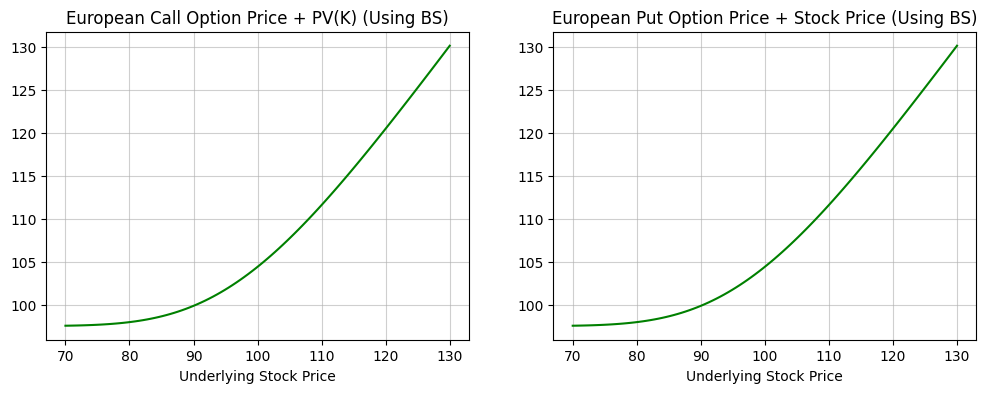

In [ ]:
european_call_prices_BS = [bs_call_price(S_init, r, sigma, 0, T, K) for S_init in stock_prices]
european_put_prices_BS = [bs_put_price(S_init, r, sigma, 0, T, K) for S_init in stock_prices]
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(stock_prices, european_call_prices_BS+pv_K,color="g")
axes[0].set_title('European Call Option Price + PV(K) (Using BS)')
axes[0].set_xlabel('Underlying Stock Price')
axes[0].grid(alpha=0.6, ls="-")

axes[1].plot(stock_prices, european_put_prices_BS+stock_prices,color="g")
axes[1].set_title('European Put Option Price + Stock Price (Using BS)')
axes[1].set_xlabel('Underlying Stock Price')
axes[1].grid(alpha=0.6, ls="-")

plt.show()

For Monte Carlo Method

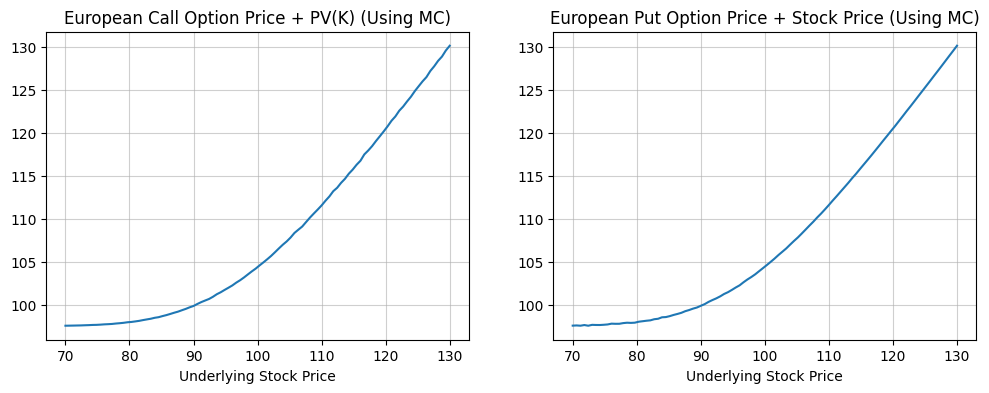

In [ ]:
european_call_prices_MC = [european_mc(S_init, K, r, sigma, T, 0, int(T * 255), 100000, 'call') for S_init in stock_prices]
european_put_prices_MC = [european_mc(S_init, K, r, sigma, T, 0, int(T*255), 100000, 'put') for S_init in stock_prices]
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(stock_prices, european_call_prices_MC+pv_K)
axes[0].set_title('European Call Option Price + PV(K) (Using MC)')
axes[0].set_xlabel('Underlying Stock Price')
axes[0].grid(alpha=0.6, ls="-")

axes[1].plot(stock_prices, european_put_prices_MC+stock_prices)
axes[1].set_title('European Put Option Price + Stock Price (Using MC)')
axes[1].set_xlabel('Underlying Stock Price')
axes[1].grid(alpha=0.6, ls="-")

plt.show()

#### *Validating the convergence of Prices*

In [ ]:
monte_carlo_call = []
monte_carlo_put = []
for i in range(1, 100000, 500):
  monte_carlo_call.append({'Iter': i, 'Monte Carlo':european_mc(S0, S0, r, sigma, T, 0, int(T * 255), i, 'call') })
  monte_carlo_put.append({'Iter': i, 'Monte Carlo':european_mc(S0, S0, r, sigma, T, 0, int(T * 255), i, 'put') })

df_call = pd.DataFrame.from_records(monte_carlo_call)
df_put = pd.DataFrame.from_records(monte_carlo_put)
#df


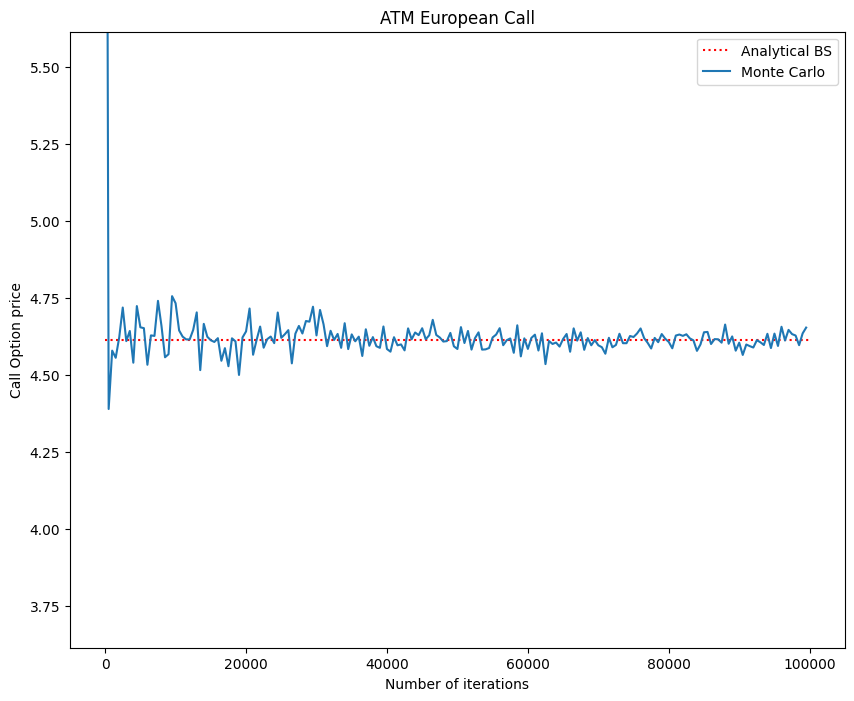

In [ ]:
plt.figure(figsize=(10, 8))

plt.hlines(
    bs_call_price(S0, r, sigma, 0, T, S0),
    xmin=0,
    xmax=100000,
    linestyle="dotted",
    colors="red",
    label="Analytical BS",
)
plt.plot(df_call.set_index("Iter"), lw=1.5, label="Monte Carlo")

plt.title("ATM European Call")
plt.xlabel("Number of iterations")
plt.ylabel("Call Option price")
plt.ylim(
    bs_call_price(S0, r, sigma, 0, T, S0) - 1,
    bs_call_price(S0, r, sigma, 0, T, S0) + 1,
)
plt.legend()
plt.show()

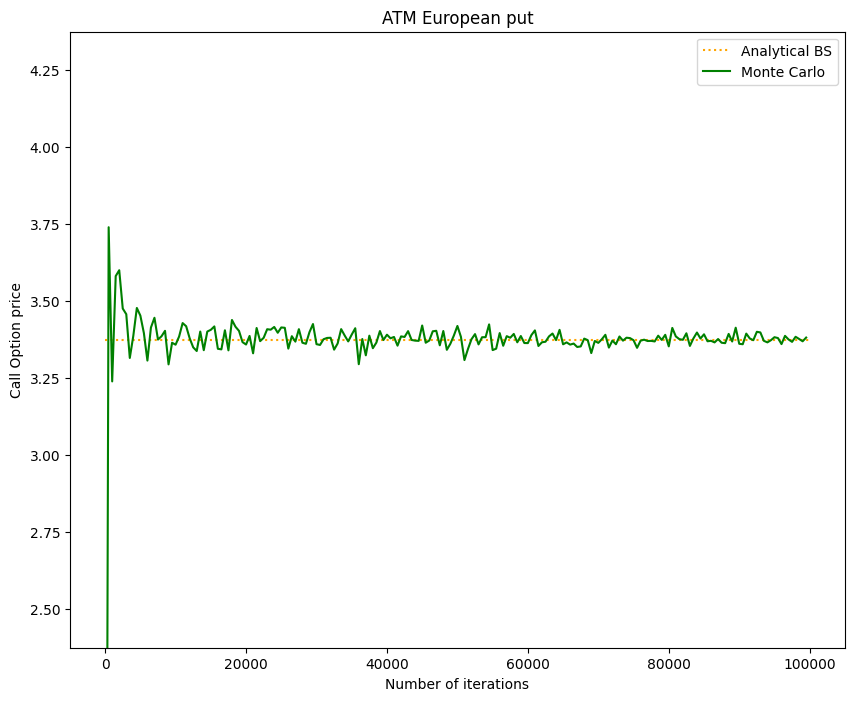

In [ ]:
plt.figure(figsize=(10, 8))

plt.hlines(
    bs_put_price(S0, r, sigma, 0, T, S0),
    xmin=0,
    xmax=100000,
    linestyle="dotted",
    colors="orange",
    label="Analytical BS",
)
plt.plot(df_put.set_index("Iter"), lw=1.5, label="Monte Carlo", color='g')

plt.title("ATM European put")
plt.xlabel("Number of iterations")
plt.ylabel("Call Option price")
plt.ylim(
    bs_put_price(S0, r, sigma, 0, T, S0) - 1,
    bs_put_price(S0, r, sigma, 0, T, S0) + 1,
)
plt.legend()
plt.show()

## **Step 2**

#### **American Options using Black-Scholes and Monte-Carlo method**

*American Call Option Using Monte-Carlo Method with GBM Process*

In [ ]:
# American call option function
def bs_american_call_mc(S, K, r, sigma, T, M, Ite):

  dt = T / M
  iters = Ite

  # Monte-Carlo Simulation of underlying prices
  underlying = np.zeros((M+1, iters))
  underlying[0] = S
  for i in range(1, M+1):
    underlying[i]= underlying[i-1]*np.exp((r - 0.5*sigma**2)*(dt) + 0.2*np.sqrt(dt)*npr.standard_normal(iters))

  prc = np.zeros((M+1, Ite)) # american call option prices

  # Option pricing
  for i in range(iters):
    prc[-1, i] = max(underlying[-1,i] - K, 0) # At the maturity the option price is just a payoff

  #print(prc)

  for j in range(M-1, -1, -1):
    for iter in range(iters):
      prc[j, iter] = max(underlying[j, iter] - K, np.exp(-r*dt)*prc[j+1, iter]) # maximum of payoff and option price (discounted)

  return sum(prc[0,:]) / iters

In [ ]:
american_call_price = bs_american_call_mc(S0, S0, r, sigma, T, int(255*T), 1_000_000)

In [ ]:
print("American call option price using Monte-Carlo simulation: ${}".format(round(american_call_price,2)))

American call option price using Monte-Carlo simulation: $8.11


The mechanism of american call option function:
1. Simulation the prices of underlying by using GBM process.
2. Setting the option price at the maturity equal to maximum between payoff and zero.
3. Backpropagation of option prices by finding the maximum of discounted option price (from the previous period) and payoff.

Delta calculation of american call option:

In [ ]:
d1 = (np.log(S0 / S0) + (r + 0.5 * sigma**2) * (1/255)) / (sigma * np.sqrt(1/255))
amer_call_option_delta = ss.norm.cdf(d1)

print("American call option delta: {}".format(round(amer_call_option_delta,4)))

American call option delta: 0.5087


Vega calculation of american call option:

In [ ]:
amer_call_option_vega = S0 * ss.norm.pdf(d1) * np.sqrt(T)
print(f"American call option vega: {round(amer_call_option_vega, 4)}")

American call option vega: 28.2027


*American Put Option Using Monte-Carlo Method with GBM Process*

In [ ]:
# American put option function
def bs_american_put_mc(S, K, r, sigma, T, M, Ite):

  dt = T / M
  iters = Ite

  # Monte-Carlo Simulation of underlying prices
  underlying = np.zeros((M+1, iters))
  underlying[0] = S
  for i in range(1, M+1):
    underlying[i]= underlying[i-1]*np.exp((r - 0.5*sigma**2)*(dt) + sigma*np.sqrt(dt)*npr.standard_normal(iters))

  prc = np.zeros((M+1, Ite)) # american call option prices

  # Option pricing
  for i in range(iters):
    prc[-1, i] = max(K - underlying[-1,i], 0) # At the maturity the option price is just a payoff

  for j in range(M-1, -1, -1):
    for iter in range(iters):
      prc[j, iter] = np.exp(-r*dt)*max(K - underlying[j, iter], prc[j+1, iter]) # maximum of payoff and option price (discounted)

  return sum(prc[0,:]) / iters

In [ ]:
american_put_price = bs_american_put_mc(S0, S0, r, sigma, T, int(255*T), 1000_000)

In [ ]:
print("American call option price using Monte-Carlo simulation: ${:.2f}".format(american_put_price))

American call option price using Monte-Carlo simulation: $6.46


Delta Calculation of American Put Option

In [ ]:
amer_put_option_delta = -ss.norm.cdf(-d1)
print("American put option delta: {:.4f}".format(amer_put_option_delta))

American put option delta: -0.4913


Vega Calculation of American Put Option

In [ ]:
amer_put_option_vega = S0 * ss.norm.pdf(d1) * np.sqrt(T)
print("American put option vega:{:.4f}".format(amer_put_option_vega))

American put option vega:28.2027


*Monte Carlo Simulation for different Level of Moneyness*

In [ ]:
K_array=[90,95,100,105,110]
call_price_arr = []
put_price_arr = []
for i in K_array:
    call_price = bs_american_call_mc(S0, i, r, sigma, T, int(255*T), 100_000)#price(100, i, 100, 1/4, 0.05, 0.2, "C")
    put_price = bs_american_put_mc(S0, i, r, sigma, T, int(T*255), 100_000)#price(100, i, 100, 1/4, 0.05, 0.2, "P")
    call_price_arr.append(call_price)
    put_price_arr.append(put_price)

In [ ]:
moneyness = ["Deep OTM","OTM", "ATM", "ITM", "Deep ITM"]
length_arr= len(K_array)

Moneyness for American Call

In [ ]:
for i in range(len(K_array)):
    print("At Strike ${1}, American Call option price when it is {0} : ${2}".format(moneyness[length_arr-i-1],K_array[i],np.round(call_price_arr[i],2)))

At Strike $90, American Call option price when it is Deep ITM : $22.15
At Strike $95, American Call option price when it is ITM : $17.19
At Strike $100, American Call option price when it is ATM : $12.27
At Strike $105, American Call option price when it is OTM : $8.07
At Strike $110, American Call option price when it is Deep OTM : $5.11


Moneyness for American Put

In [ ]:
for i in range(len(K_array)):
    print("At Strike ${1}, American Put option price when it is {0} : ${2}".format(moneyness[i],K_array[i],np.round(put_price_arr[i],2)))

At Strike $90, American Put option price when it is Deep OTM : $2.47
At Strike $95, American Put option price when it is OTM : $5.0
At Strike $100, American Put option price when it is ATM : $8.92
At Strike $105, American Put option price when it is ITM : $13.89
At Strike $110, American Put option price when it is Deep ITM : $18.87


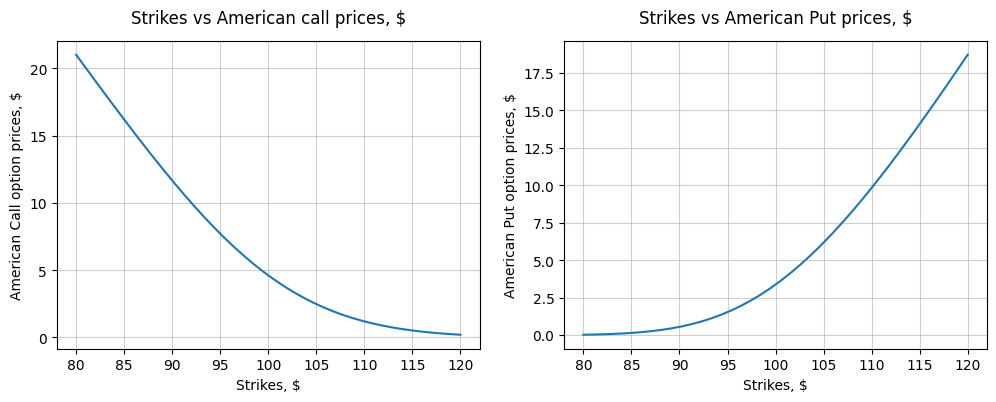

In [ ]:
strikes = list(np.linspace(80, 120, 40))
amer_call_price_arr = [bs_call_price(S0, r, sigma, 0, T, strike) for strike in strikes]
amer_put_price_arr = [bs_put_price(S0, r, sigma, 0, T, strike) for strike in strikes]

# Plotting graphs
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(strikes, amer_call_price_arr)
axes[0].set_title("Strikes vs American call prices, $", y = 1.03)
axes[0].set_xlabel("Strikes, $")
axes[0].set_ylabel("American Call option prices, $")
axes[0].grid(alpha=0.6, ls="-")

axes[1].plot(strikes, amer_put_price_arr)
axes[1].set_title("Strikes vs American Put prices, $", y = 1.03)
axes[1].set_xlabel("Strikes, $")
axes[1].set_ylabel("American Put option prices, $")
axes[1].grid(alpha=0.6, ls="-")
plt.show()

# **Step 3**

#### **Hedging European Options using Black-Scholes & Pricing Exotic instruments**

Pricing European call option with 110% moneyness and European put with 95% moneyness using Black-Scholes

In [ ]:
strikes = {"call": 1.1, "put": 0.95}

euro_call_price = bs_call_price(S0, r, sigma, 0, T, S0*strikes["call"])
euro_put_price = bs_call_price(S0, r, sigma, 0, T, S0*strikes["put"])

print("European call option price: {}".format(round(euro_call_price,2)))
print("European put option price: {}".format(round(euro_put_price,2)))

European call option price: 2.91
European put option price: 9.87


Building portfolio: buy call and put

In [ ]:
# Computing the portfolio delta

# Call option
d1_call = (np.log(S0 / S0*strikes["call"]) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
call_option_delta = ss.norm.cdf(d1_call)
# Put option
d1_put = (np.log(S0 / S0*strikes["put"]) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
put_option_delta = -ss.norm.cdf(-d1_put)

print("Buy call and put strategy:")
print(f"  Call option delta: {round(call_option_delta, 4)}")
print(f"  Put option delta: {round(put_option_delta, 4)}")
print(f"  Portfolio delta: {round(call_option_delta+put_option_delta, 4)}")

Buy call and put strategy:
  Call option delta: 0.8216
  Put option delta: -0.5459
  Portfolio delta: 0.2757


In order to delta-hedge the portfolio each option will be delta-hedged seperately by using individual deltas of each option.

The following operation will be corrected in accordance to delta-hedge changes.    

Building portfolio: buy call and sell put

In [ ]:
print("Buy call and sell put strategy:")
print(f"   Call option delta: {round(call_option_delta, 4)}")
print(f"   Put option delta: {round(put_option_delta, 4)}")
print(f"   Portfolio delta: {round(call_option_delta-put_option_delta, 4)}")

Buy call and sell put strategy:
   Call option delta: 0.8216
   Put option delta: -0.5459
   Portfolio delta: 1.3674


In order to delta-hedge the portfolio each option will be delta-hedged seperately by using individual deltas of each option.

The following operation will be corrected in accordance to delta-hedge changes.

#### **Pricing Up-and-Out (UAO) barrier ATM option.**

In [ ]:
S0 = 120
barrier = 141
r = 0.06
sigma = 0.3
T = 8/12 # 8 months

In [ ]:
def mc_uao_pricing(S, K, barrier, r, sigma, T, M, iters):
  sum_price = 0
  dt = T/M

  for i in range(iters):
    stop = False
    St = S
    for t in range(M):
      Stn = St * np.exp((r - 0.5*sigma**2)*(dt) + sigma*np.sqrt(dt)*np.random.normal())
      St = Stn
      if St >= barrier:
        stop = True
        break

    if stop == True:
      price = 0
    else:
      price = max(0, K - St)

    sum_price += price
  return np.exp(-r * T) * sum_price/iters

In [ ]:
price_uao_mc = mc_uao_pricing(S0, S0, barrier, r, sigma, T, int(255*T), 100_000)
print("Up-and-Out option price with barrier of ${} is ${}".format(barrier, round(price_uao_mc,2)))

Up-and-Out option price with barrier of $141 is $8.38


#### **Pricing Up-and-In (UAI) barrier ATM option.**

In [ ]:
def mc_uai_pricing(S, K, barrier, r, sigma, T, M, iters):

    dt = T / M
    sum_price = 0

    for i in range(iters):
      stop = False
      St = S
      for t in range(M):
          Stn = St * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn())
          St = Stn
          #print (St)
          if St <= barrier:
            stop = True
            break

      if stop:
        price = 0
      else:
        price = max(0,  St - K )

    sum_price += price
    return (np.exp(-r * T) * sum_price)/iters

In [ ]:
price_uai_mc = mc_uai_pricing(S0, S0, barrier, r, sigma, T, int(255*T), 100_000)
print("Up-and-In option price with barrier of ${} is ${}".format(barrier, round(price_uai_mc,4)))

Up-and-In option price with barrier of $141 is $0.0


####**Pricing vanilla ATM options.**

In [ ]:
call_price = european_mc(S0, S0, r, sigma, T, 0, int(T * 255), 100_000, 'call')
print('ATM European call option price: ${:.2f}'.format(call_price))

put_price = european_mc(S0, S0, r, sigma, T, 0, int(T*255), 100_000, 'put')
print('ATM European put option price: ${:.2f}'.format(put_price))

ATM European call option price: $13.93
ATM European put option price: $9.20
